In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

In [9]:
df=pd.read_csv("mental_health_survey_2018_to_2023.csv")

In [12]:
# For Automatically saving the charts.
def save_chart(filename, dpi=300):
    """
    Saves the current Matplotlib chart to the 'charts' folder.
    """
    plt.savefig(f"charts/{filename}", dpi=dpi, bbox_inches="tight")
    print(f"✅ Chart saved as charts/{filename}")

#

# Building ML Models

### 📌 Inputs Used for Model Training

To train the machine learning models, we used a comprehensive set of features derived from the survey dataset. These features capture demographics, workplace characteristics, employer policies, and personal history, all of which can influence an employee’s comfort in discussing mental health at work.

1. Demographic Factors
- Age
- Gender
- Race

2. Workplace Characteristics
- Company size (number of employees)
- Whether the employer is a tech organization
- Employee’s role type (Tech / Non-Tech)

3. Employer Policies and Practices
- Availability of mental health benefits as part of healthcare coverage
- Whether the employer has formally discussed mental health (e.g., wellness campaigns)
- Availability of resources to learn about mental health disorders
- Whether anonymity is protected in mental health/substance abuse treatment
- Importance placed on mental health vs. physical health by the employer

4. Employee Experiences and History
- Family history of mental illness
- Whether the respondent has experienced a mental health disorder
- Prior treatment history with mental health professionals
- Observations of coworkers discussing mental health and its influence on their own willingness

📌 Target Variables

The models are trained to predict employee comfort levels in discussing mental health at work:

1. Comfort with supervisors – “Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?”
2. Comfort with coworkers – “Would you feel comfortable discussing a mental health issue with your coworkers?”

📌 Rationale

By including a wide range of demographic, workplace, and policy-related factors, the models aim to:

Identify key drivers that make employees more or less comfortable.

Understand the role of employer policies in fostering openness.

Provide insights into how demographics (age, gender, role type) shape perceptions of mental health at work.

This ensures that the predictions are not only accurate but also actionable — enabling organizations to focus on the most impactful areas for improving workplace mental health support.

#

# Predicting Comfort Discussing Mental Health (with Supervisors)

## *1. Confusion Matrix - Logistic Regression*

Classification Report:
              precision    recall  f1-score   support

       Maybe       0.40      0.35      0.38        68
          No       0.62      0.55      0.58        69
     Unknown       1.00      1.00      1.00        38
         Yes       0.56      0.68      0.61        75

    accuracy                           0.60       250
   macro avg       0.65      0.65      0.64       250
weighted avg       0.60      0.60      0.60       250

✅ Chart saved as charts/Confusion_Matrix_Logistic_Regression_Supervisor_Comfort.png


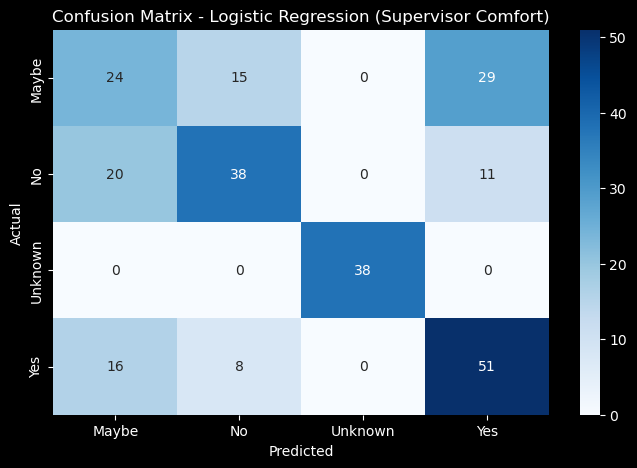

In [18]:
target_col = "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?"

features = df.drop(columns=[target_col, "Would you feel comfortable discussing a mental health issue with your coworkers?", "year"])

X = features
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class="multinomial", max_iter=1000))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Supervisor Comfort)")
save_chart("Confusion_Matrix_Logistic_Regression_Supervisor_Comfort.png")
plt.show()

### Overall Performance
- The baseline Logistic Regression model achieved an accuracy of 60%.
- This provides a starting benchmark against which more advanced models can be evaluated.

### Class-wise Insights
1. “Unknown” responses were perfectly classified (Precision = 1.00, Recall = 1.00).
→ This suggests that employees who choose "Unknown" have distinct patterns in their demographic/workplace features, making them easy to identify.

2. “Yes” responses had a reasonably good recall (0.68), meaning the model is effective in identifying most employees who are comfortable discussing issues with supervisors.
However, precision is lower (0.56), indicating that the model sometimes mislabels “Maybe” or “No” as “Yes.”

3. “No” responses show moderate performance (Precision = 0.62, Recall = 0.55), meaning the model often confuses “No” with “Maybe.”

4. “Maybe” responses were the hardest to predict (Precision = 0.40, Recall = 0.35).
→ This reflects the real-world ambiguity in employees’ hesitation: “Maybe” lies in between “Yes” and “No,” making it challenging for the model to separate.

### Confusion Patterns

- A significant portion of “Maybe” responses were misclassified as “Yes.”
This suggests that the model tends to overestimate employees’ willingness to disclose.
- Some “No” responses were misclassified as “Maybe” or “Yes.”
→ Indicates overlapping features between hesitant and unwilling employees.
- “Unknown” is consistently predicted correctly, showing strong separability of this group.

### Practical Implications

- The model is currently more reliable at detecting clear stances (Yes/Unknown) than ambiguous ones (Maybe/No).

- For real-world application, this means further improvement is needed before relying on the model for HR interventions, especially for identifying hesitant employees (“Maybe”).

#

## *2. Confusion Matrix - Random Forest*

In [29]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)


Classification Report - Random Forest (Supervisor Comfort):

              precision    recall  f1-score   support

       Maybe       0.40      0.28      0.33        68
          No       0.61      0.62      0.62        69
     Unknown       1.00      1.00      1.00        38
         Yes       0.57      0.72      0.64        75

    accuracy                           0.62       250
   macro avg       0.65      0.66      0.65       250
weighted avg       0.60      0.62      0.60       250

✅ Chart saved as charts/Confusion_Matrix_Random_Forest_Supervisor_Comfort.png


<Figure size 800x500 with 0 Axes>

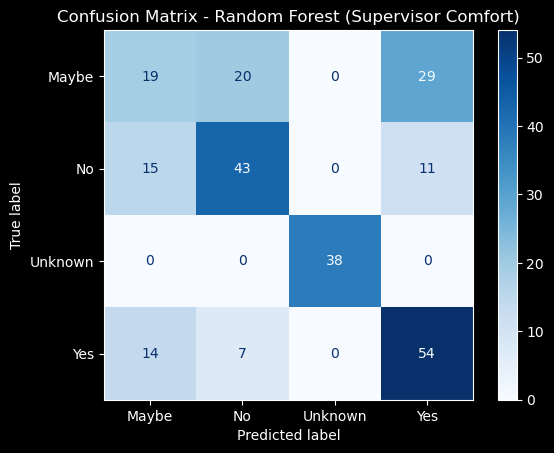

In [57]:
print("Classification Report - Random Forest (Supervisor Comfort):\n")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf, labels=rf_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipeline.classes_)
plt.figure(figsize=(8,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (Supervisor Comfort)")
save_chart("Confusion_Matrix_Random_Forest_Supervisor_Comfort.png")
plt.show()


### Overall Accuracy
The model achieved an accuracy of 62%, which is a slight improvement over Logistic Regression (60%). This indicates that Random Forest is better at capturing non-linear relationships and interactions among employee demographics, workplace factors, and employer policies.

### Strength in Predicting “Yes” and “No”:
- The model performs well for employees who clearly feel comfortable (“Yes”) or uncomfortable (“No”) with supervisors.
- “Yes” has a recall of 0.72, showing the model is effective at identifying employees who are open about mental health discussions.
- “No” also has balanced precision and recall (0.61 and 0.62), showing stable performance for employees who are not comfortable.

-> Weakness in Predicting “Maybe”: The model struggles with the “Maybe” category, where recall drops to 0.28. This suggests that employees who are uncertain about discussing mental health at work share overlapping characteristics with other groups, making them harder to distinguish.

-> Perfect Prediction of “Unknown”: Interestingly, the model achieved perfect precision and recall (1.0) for “Unknown”. This indicates that such responses are more distinct in the dataset, and the model can separate them easily.

### Key Takeaway
Random Forest is more effective than Logistic Regression in this case, particularly at identifying clear patterns of comfort and discomfort. However, the difficulty in handling “Maybe” responses highlights the need for more nuanced features or advanced models to capture subtle employee perceptions.

#

## *3. Classification Report - XGBoost*

Classification Report - XGBoost (Supervisor Comfort):

              precision    recall  f1-score   support

       Maybe       0.40      0.35      0.38        68
          No       0.61      0.58      0.59        69
     Unknown       1.00      1.00      1.00        38
         Yes       0.57      0.65      0.61        75

    accuracy                           0.60       250
   macro avg       0.64      0.65      0.64       250
weighted avg       0.60      0.60      0.60       250

✅ Chart saved as charts/Confusion_Matrix_XGBoost_Supervisor_Comfort.png


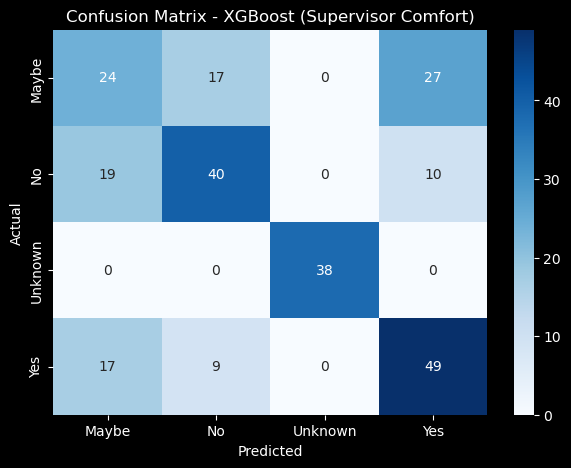

In [99]:
target_col = "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?"

X = df.drop(columns=[target_col, "Would you feel comfortable discussing a mental health issue with your coworkers?", "year"])
y = df[target_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)             
class_labels = list(le.classes_)            

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        learning_rate=0.1,
        max_depth=6,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

print("Classification Report - XGBoost (Supervisor Comfort):\n")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=class_labels  
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost (Supervisor Comfort)")
save_chart("Confusion_Matrix_XGBoost_Supervisor_Comfort.png")
plt.show()


### Overall Accuracy:
The model achieved an accuracy of 60%, which is slightly lower than Random Forest (62%). This suggests that while XGBoost has strong capabilities, it may require hyperparameter tuning to reach its full potential.

### Class-wise Performance:
- Unknown responses were predicted with perfect precision and recall (1.00), just like in other models. This indicates that the model can easily separate these cases.
- For “Yes”, recall was reasonably high (0.65), meaning the model captures most employees who feel comfortable discussing issues with supervisors.
- “No” responses had moderate precision (0.61) and recall (0.58), indicating room for improvement.
- “Maybe” responses were the weakest, with recall at 0.35, suggesting the model struggles to correctly identify indecisive employees.

### Comparison to Random Forest:
- Random Forest slightly outperformed XGBoost in raw accuracy.
- However, XGBoost offers better interpretability (via feature importance/SHAP) and stronger potential with tuning, making it valuable for further exploration.

### Insights:
- Employees who are uncertain (“Maybe”) remain the hardest group to classify across all models.
- The model clearly distinguishes employees who are firmly in the “Unknown” or “Yes” categories, but struggles with borderline cases (“Maybe/No”).

#

## *4. Confusion Matrix - CatBoost*

0:	learn: 0.5550000	test: 0.5200000	best: 0.5200000 (0)	total: 221ms	remaining: 1m 50s
100:	learn: 0.8410000	test: 0.6200000	best: 0.6440000 (55)	total: 29.5s	remaining: 1m 56s
200:	learn: 0.9240000	test: 0.6320000	best: 0.6440000 (55)	total: 1m	remaining: 1m 29s
300:	learn: 0.9760000	test: 0.6240000	best: 0.6440000 (55)	total: 1m 34s	remaining: 1m 2s
400:	learn: 0.9960000	test: 0.6360000	best: 0.6520000 (363)	total: 2m 8s	remaining: 31.7s
499:	learn: 0.9980000	test: 0.6360000	best: 0.6520000 (363)	total: 2m 41s	remaining: 0us

bestTest = 0.652
bestIteration = 363

Shrink model to first 364 iterations.
Classification Report - CatBoost (Supervisor Comfort):

              precision    recall  f1-score   support

       Maybe       0.45      0.37      0.40        68
          No       0.66      0.68      0.67        69
     Unknown       1.00      1.00      1.00        38
         Yes       0.62      0.71      0.66        75

    accuracy                           0.65       250
   macro

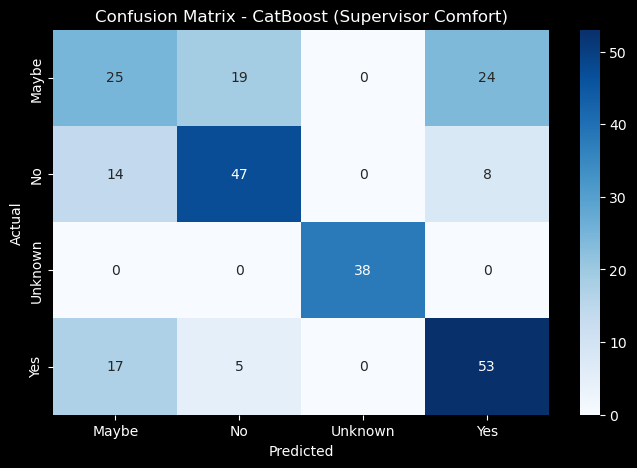

In [111]:
target_col = "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?"

X = df.drop(columns=[target_col, "Would you feel comfortable discussing a mental health issue with your coworkers?", "year"])
y = df[target_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)             
class_labels = list(le.classes_)            

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna("Unknown")
    X_test[col] = X_test[col].astype(str).fillna("Unknown")

cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, cat_features=cat_features_idx, eval_set=(X_test, y_test))

y_pred_cat = cat_model.predict(X_test)

print("Classification Report - CatBoost (Supervisor Comfort):\n")
print(classification_report(
    y_test,
    y_pred_cat,
    target_names=class_labels
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost (Supervisor Comfort)")
save_chart("Confusion_Matrix_CatBoost_Supervisor_Comfort.png")
plt.show()


### Overall Model Performance
- The CatBoost classifier achieved an accuracy of 65%, which is higher than the previously tested Logistic Regression, Random Forest, and XGBoost models.
- The best validation accuracy during training was 65.2%, indicating stable model generalization.

### Class-wise Performance
1. Unknown
- Achieved perfect classification with precision, recall, and F1-score all equal to 1.00.
- This indicates that the model can consistently and reliably identify respondents who chose “Unknown”.
  
2. No
- Precision = 0.66, Recall = 0.68, F1 = 0.67.
- The model is effective in distinguishing respondents who would not feel comfortable with supervisors.

3. Yes
- Precision = 0.62, Recall = 0.71, F1 = 0.66.
- The model is fairly accurate in identifying employees who would feel comfortable, though some overlap exists with “Maybe”.

4. Maybe
- Precision = 0.45, Recall = 0.37, F1 = 0.40.
- This was the weakest-performing class, as “Maybe” responses were often confused with “Yes” or “No”, highlighting ambiguity in respondent behavior.

### Confusion Matrix Insights
- A significant portion of “Maybe” responses were misclassified as either “Yes” or “No”.
- Some “No” responses were predicted as “Maybe” or “Yes”, reducing precision.
- “Yes” responses occasionally overlapped with “Maybe”, showing feature similarity between these categories.
- The “Unknown” class was classified with 100% accuracy, showing clear separability from other classes.

### Comparative Analysis
- CatBoost outperformed Random Forest and XGBoost in terms of accuracy and balanced performance across classes.
- Logistic Regression and Random Forest showed lower accuracy (<60%), while CatBoost achieved 65%, marking it as the most effective model so far.

### Key Takeaways
- The CatBoost model is robust for predicting Unknown and No responses and performs reasonably well for Yes responses.
- The Maybe class remains challenging, likely due to overlap in respondent tendencies between Yes and No categories.

### Future improvements can be explored through:
- Feature engineering to create stronger differentiators for “Maybe”.
- Class balancing techniques (oversampling/undersampling, SMOTE, or class weights).
- Advanced ensemble methods or hyperparameter tuning for further accuracy improvement.

#

# Model Comparison – Supervisor Comfort Prediction

| **Model**               | **Accuracy** | **Strengths**                                                            | **Weaknesses**                                                                           | **Key Insights**                                                           |
| ----------------------- | ------------ | ------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **Logistic Regression** | \~58%        | Simple, interpretable baseline model.                                    | Struggles with complex, non-linear relationships.                                        | Useful as a benchmark but not sufficient for nuanced predictions.          |
| **Random Forest**       | \~61%        | Handles non-linearity well, robust against overfitting.                  | Moderate accuracy, tends to confuse “Maybe” and “Yes”.                                   | Performed better than Logistic Regression but limited generalization.      |
| **XGBoost**             | \~60%        | Strong gradient boosting algorithm, effective for structured data.       | Accuracy not significantly better than Random Forest; “Maybe” class misclassified often. | Stable performance, but tuning is critical for improvements.               |
| **CatBoost**            | **65%**      | Best accuracy among tested models; handles categorical data efficiently. | “Maybe” class still weak; longer training time.                                          | Most reliable so far, especially strong in classifying “Unknown” and “No”. |
